(sec:reg)=
# Regularization

As discussed in previous chapters, one of the strengths of the neural networks is that they can approximate any continuous functions when a sufficient number of parameters is used.
When using universal approximators in machine learning settings, an important related risk is that of overfitting the training data.
More formally, given a training dataset $\mathcal{D}_t$ drawn from an unknown distribution $\mathcal{D}$, model parameters are optimized so as to minimize the empirical risk:

$$
  \mathcal{R}_e(\theta) = \frac{1}{|\mathcal{D}_t|} \sum_{(x_i, y_i) \in \mathcal{D}_t} \mathcal{L}(x_i, y_i ; m_\theta)
$$

whereas the real objective is to minimize the "true" risk:

$$
  \mathcal{R}(\theta) = \mathbb{E}_{x, y \sim \mathcal{D}} \mathcal{L}(x, y; m_\theta)
$$

and both objectives do not have the same minimizer.

To avoid this pitfall, one should use regularization techniques, such as the ones presented in the following.

## Early Stopping

As illustrated below, it can be observed that training a neural network for a too large number of epochs can lead to overfitting.
Note that here, the true risk is estimated through the use of a validation set that is not seen during training.

In [1]:
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from notebook_utils import prepare_notebook_graphics
import keras_core as keras
from keras.utils import to_categorical
from myst_nb import glue
prepare_notebook_graphics()

Using TensorFlow backend


2023-08-21 16:04:15.672196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:04:15.735887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:04:15.736991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-08-21 16:04:16.987539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
iris = pd.read_csv("../data/iris.csv", index_col=0)
iris = iris.sample(frac=1)
y = to_categorical(iris["target"])
X = iris.drop(columns=["target"])
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [3]:
import keras_core as keras
from keras.layers import Dense, InputLayer
from keras.models import Sequential
from keras.utils import set_random_seed


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

23

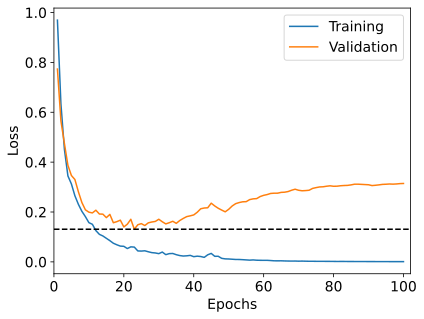

In [4]:
plt.plot(np.arange(1, n_epochs + 1), h.history["loss"], label="Training")
plt.plot(np.arange(1, n_epochs + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 102])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

glue("epoch_best_model", np.argmin(h.history["val_loss"]) + 1, display=False)

Here, the best model (in terms of generalization capabilities) seems to be the model at epoch {glue:}`epoch_best_model`.
In other words, if we had stopped the learning process after epoch {glue:}`epoch_best_model`, we would have gotten a better model than if we use the model trained during 70 epochs.

This is the whole idea behind the "early stopping" strategy, which consists in stopping the learning process as soon as the validation loss stops improving.
As can be seen in the visualization above, however, the validation loss tends to oscillate, and one often waits for several epochs before assuming that the loss is unlikely to improve in the future.
The number of epochs to wait is called the _patience_ parameter.

In `keras`, early stopping can be set up via a callback, as in the following example:

In [5]:
from keras.callbacks import EarlyStopping


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, 
              validation_split=0.3, epochs=n_epochs, batch_size=30, 
              verbose=0, callbacks=[cb_es])

23

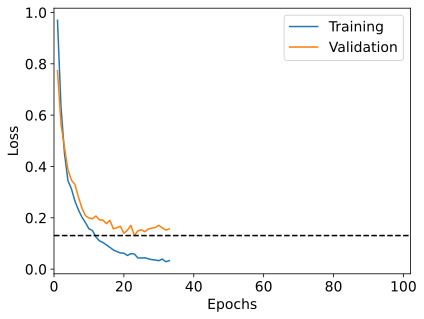

In [6]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Training")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 102])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

glue("epoch_best_model_es", np.argmin(h.history["val_loss"]) + 1, display=False)

And now, even is the model was scheduled to be trained for 70 epochs, training is stopped as soon as it reaches 10 consecutive epochs without improving on the validation loss, and the model parameters are restored as the parameters of the model at epoch {glue:}`epoch_best_model_es`.


## Loss penalization

Another important way to enforce regularization in neural networks is through loss penalization.
A typical instance of this regularization strategy is the L2 regularization.
If we denote by $\mathcal{L}_r$ the L2-regularized loss, it can be expressed as:

$$
  \mathcal{L}_r(\mathcal{D} ; m_\theta) = \mathcal{L}(\mathcal{D} ; m_\theta) + \lambda \sum_{\ell} \| \theta^{(\ell)} \|_2^2
$$

where $\theta^{(\ell)}$ is the weight matrix of layer $\ell$.

This regularization tends to shrink large parameter values during the learning process, which is known to help improve generalization.

In `keras`, this is implemented as:

In [7]:
from keras.regularizers import L2

λ = 0.01

set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

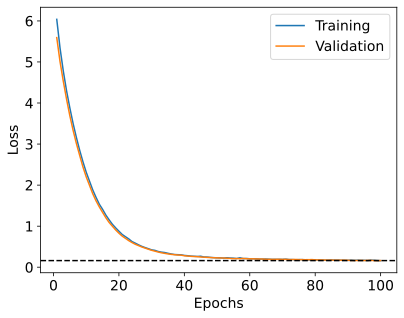

In [8]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Training")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## DropOut

```{tikz} Illustration of the DropOut mechanism. In order to train a given model (left), at each mini-batch, a given proportion of neurons is picked at random to be "switched off" and the subsequent sub-network is used for the current optimization step (_cf._ right-hand side figure, in which 40% of the neurons -- coloured in gray -- are switched off).
    % Model 0
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0_model0) at  (0, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in1_model0) at  (0, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in2_model0) at  (0, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3_model0) at  (0, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4_model0) at  (0, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_0) at  (2, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_1) at  (2, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_2) at  (2, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_3) at  (2, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_4) at  (2, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_0) at  (4, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_1) at  (4, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_2) at  (4, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_3) at  (4, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_4) at  (4, 1) {};
    
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (out_0_model0) at  (6, 3) {};

    \draw[->] (in0_model0) -- (h1_model0_0);
    \draw[->] (in0_model0) -- (h1_model0_1);
    \draw[->] (in0_model0) -- (h1_model0_2);
    \draw[->] (in0_model0) -- (h1_model0_3);
    \draw[->] (in0_model0) -- (h1_model0_4);
    \draw[->] (in1_model0) -- (h1_model0_0);
    \draw[->] (in1_model0) -- (h1_model0_1);
    \draw[->] (in1_model0) -- (h1_model0_2);
    \draw[->] (in1_model0) -- (h1_model0_3);
    \draw[->] (in1_model0) -- (h1_model0_4);
    \draw[->] (in2_model0) -- (h1_model0_0);
    \draw[->] (in2_model0) -- (h1_model0_1);
    \draw[->] (in2_model0) -- (h1_model0_2);
    \draw[->] (in2_model0) -- (h1_model0_3);
    \draw[->] (in2_model0) -- (h1_model0_4);
    \draw[->] (in3_model0) -- (h1_model0_0);
    \draw[->] (in3_model0) -- (h1_model0_1);
    \draw[->] (in3_model0) -- (h1_model0_2);
    \draw[->] (in3_model0) -- (h1_model0_3);
    \draw[->] (in3_model0) -- (h1_model0_4);
    \draw[->] (in4_model0) -- (h1_model0_0);
    \draw[->] (in4_model0) -- (h1_model0_1);
    \draw[->] (in4_model0) -- (h1_model0_2);
    \draw[->] (in4_model0) -- (h1_model0_3);
    \draw[->] (in4_model0) -- (h1_model0_4);

    \draw[->] (h1_model0_0) -- (h2_model0_0);
    \draw[->] (h1_model0_0) -- (h2_model0_1);
    \draw[->] (h1_model0_0) -- (h2_model0_2);
    \draw[->] (h1_model0_0) -- (h2_model0_3);
    \draw[->] (h1_model0_0) -- (h2_model0_4);
    \draw[->] (h1_model0_1) -- (h2_model0_0);
    \draw[->] (h1_model0_1) -- (h2_model0_1);
    \draw[->] (h1_model0_1) -- (h2_model0_2);
    \draw[->] (h1_model0_1) -- (h2_model0_3);
    \draw[->] (h1_model0_1) -- (h2_model0_4);
    \draw[->] (h1_model0_2) -- (h2_model0_0);
    \draw[->] (h1_model0_2) -- (h2_model0_1);
    \draw[->] (h1_model0_2) -- (h2_model0_2);
    \draw[->] (h1_model0_2) -- (h2_model0_3);
    \draw[->] (h1_model0_2) -- (h2_model0_4);
    \draw[->] (h1_model0_3) -- (h2_model0_0);
    \draw[->] (h1_model0_3) -- (h2_model0_1);
    \draw[->] (h1_model0_3) -- (h2_model0_2);
    \draw[->] (h1_model0_3) -- (h2_model0_3);
    \draw[->] (h1_model0_3) -- (h2_model0_4);
    \draw[->] (h1_model0_4) -- (h2_model0_0);
    \draw[->] (h1_model0_4) -- (h2_model0_1);
    \draw[->] (h1_model0_4) -- (h2_model0_2);
    \draw[->] (h1_model0_4) -- (h2_model0_3);
    \draw[->] (h1_model0_4) -- (h2_model0_4);

    \draw[->] (h2_model0_0) -- (out_0_model0);
    \draw[->] (h2_model0_1) -- (out_0_model0);
    \draw[->] (h2_model0_2) -- (out_0_model0);
    \draw[->] (h2_model0_3) -- (out_0_model0);
    \draw[->] (h2_model0_4) -- (out_0_model0);

    % Model 1
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0_model1) at  (8, 5) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (in1_model1) at  (8, 4) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (in2_model1) at  (8, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3_model1) at  (8, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4_model1) at  (8, 1) {};

    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h1_model1_0) at  (10, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_1) at  (10, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_2) at  (10, 3) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h1_model1_3) at  (10, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_4) at  (10, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_0) at  (12, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_1) at  (12, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_2) at  (12, 3) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h2_model1_3) at  (12, 2) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h2_model1_4) at  (12, 1) {};
    
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (out_0_model1) at  (14, 3) {};

    \draw[->] (in0_model1) -- (h1_model1_1);
    \draw[->] (in0_model1) -- (h1_model1_2);
    \draw[->] (in0_model1) -- (h1_model1_4);
    \draw[->] (in3_model1) -- (h1_model1_1);
    \draw[->] (in3_model1) -- (h1_model1_2);
    \draw[->] (in3_model1) -- (h1_model1_4);
    \draw[->] (in4_model1) -- (h1_model1_1);
    \draw[->] (in4_model1) -- (h1_model1_2);
    \draw[->] (in4_model1) -- (h1_model1_4);

    \draw[->] (h1_model1_1) -- (h2_model1_0);
    \draw[->] (h1_model1_1) -- (h2_model1_1);
    \draw[->] (h1_model1_1) -- (h2_model1_2);
    \draw[->] (h1_model1_2) -- (h2_model1_0);
    \draw[->] (h1_model1_2) -- (h2_model1_1);
    \draw[->] (h1_model1_2) -- (h2_model1_2);
    \draw[->] (h1_model1_4) -- (h2_model1_0);
    \draw[->] (h1_model1_4) -- (h2_model1_1);
    \draw[->] (h1_model1_4) -- (h2_model1_2);

    \draw[->] (h2_model1_0) -- (out_0_model1);
    \draw[->] (h2_model1_1) -- (out_0_model1);
    \draw[->] (h2_model1_2) -- (out_0_model1);
```


In this section, we present the DropOut strategy, which was introduced in {cite}`JMLR:v15:srivastava14a`.
The idea behind DropOut is to _switch off_ some of the neurons during training.
The switched off neurons change at each mini-batch such that, overall, all neurons are trained during the whole process.

The concept is very similar in spirit to a strategy that is used for training random forest, which consists in randomly selecting candidate variables for each tree split inside a forest, which is known to lead to better generalization performance for random forests.
The main difference here is that one can not only switch off _input neurons_ but also _hidden-layer ones_ during training.

In `keras`, this is implemented as a layer, which acts by switching off neurons from the previous layer in the network:

In [9]:
from keras.layers import Dropout

set_random_seed(0)
switchoff_proba = 0.3
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

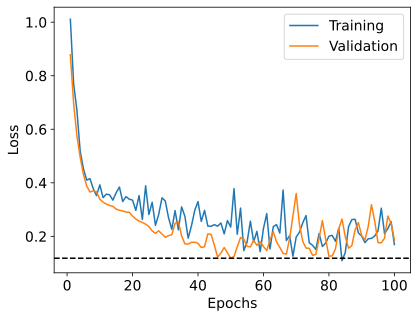

In [10]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Training")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

````{admonition} Exercise #1

When observing the loss values in the figure above, can you explain why the validation loss is almost consistently lower than the training one?

```{admonition} Solution
:class: dropdown, tip

In fact, the training loss is computed as the average loss over all training mini-batches during an epoch.
Now, if we recall that during training, at each minibatch, 30% of the neurons are switched-off, one can see that only a subpart of the full model is used when evaluating the training loss while the full model is retrieved when predicting on the validation set, which explains why the measured validation loss is lower than the training one.
```
````


## References

```{bibliography}
:filter: docname in docnames
```